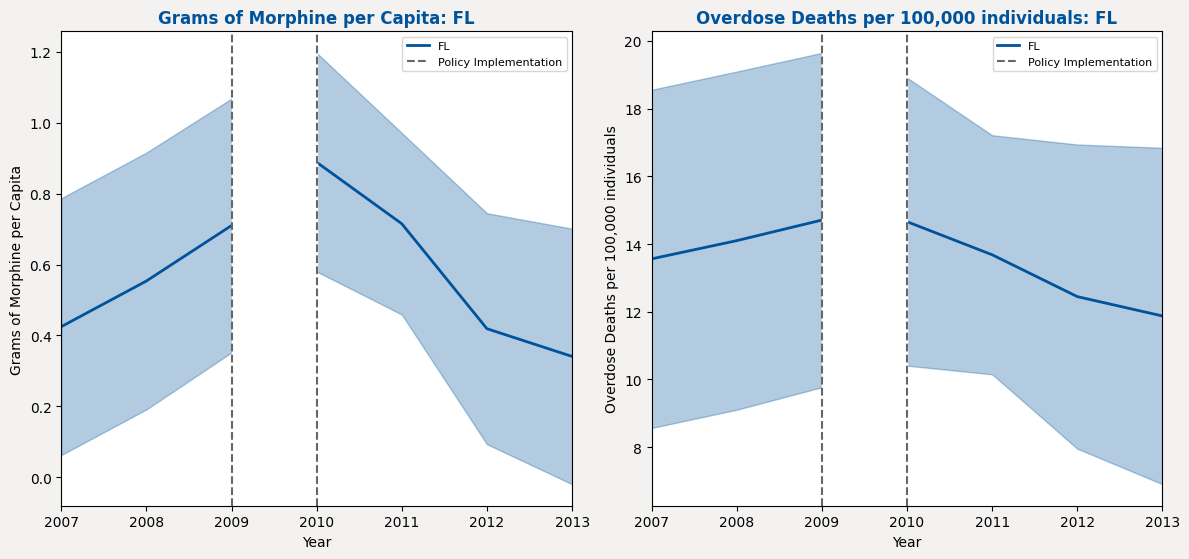

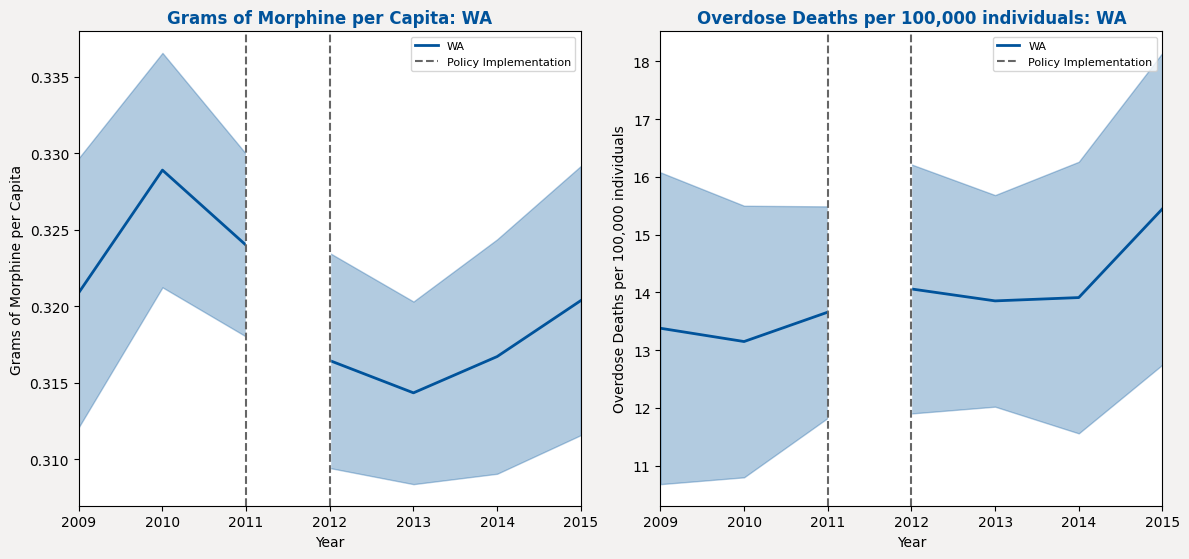

In [6]:
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd


def add_policy_year_break(ax, break_year_start, break_year_end):
    """Add a shaded vertical area to highlight the policy year range."""
    ax.axvspan(
        break_year_start,
        break_year_end,
        color="white",
        alpha=1.0,
        zorder=2,
        edgecolor=None,
    )
    return ax


def create_did_chart_splines_with_extra_line(
    final_dataset,
    state,
    start_year,
    end_year,
    policy_year_start,
    policy_year_end,
    extra_line_year,
):
    final_dataset["opioid_YEAR"] = pd.to_numeric(
        final_dataset["opioid_YEAR"], errors="coerce"
    )
    final_dataset = final_dataset.dropna(subset=["opioid_YEAR"])

    final_dataset = final_dataset[
        (final_dataset["opioid_YEAR"] >= start_year)
        & (final_dataset["opioid_YEAR"] <= end_year)
    ]

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "background": "#F3F2F1",
    }

    state_data = final_dataset[final_dataset["State"] == state]

    # Compute total population and log-transformed total population
    state_aggregated = (
        state_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    state_aggregated["log_population"] = np.log(state_aggregated["total_population"])
    state_aggregated["morphine_per_capita"] = (
        state_aggregated["total_morphine"] / state_aggregated["total_population"]
    )
    # Adjust deaths metric to deaths per 100k people
    state_aggregated["deaths_per_100k"] = (
        state_aggregated["total_deaths"] / state_aggregated["total_population"]
    ) * 100000

    # Add spline terms for opioid_YEAR
    spline_year = dmatrix(
        "bs(opioid_YEAR, degree=3, df=4)",
        data=state_aggregated,
        return_type="dataframe",
    )

    # Regression models with splines and log population
    morphine_model = sm.OLS(
        state_aggregated["morphine_per_capita"],
        sm.add_constant(
            pd.concat([spline_year, state_aggregated["log_population"]], axis=1)
        ),
    ).fit()
    morphine_predictions = morphine_model.get_prediction(
        sm.add_constant(
            pd.concat([spline_year, state_aggregated["log_population"]], axis=1)
        )
    ).summary_frame()
    state_aggregated["morphine_predicted"] = morphine_predictions["mean"]
    state_aggregated["morphine_ci_low"] = morphine_predictions["mean_ci_lower"]
    state_aggregated["morphine_ci_high"] = morphine_predictions["mean_ci_upper"]

    deaths_model = sm.OLS(
        state_aggregated["deaths_per_100k"],
        sm.add_constant(
            pd.concat([spline_year, state_aggregated["log_population"]], axis=1)
        ),
    ).fit()
    deaths_predictions = deaths_model.get_prediction(
        sm.add_constant(
            pd.concat([spline_year, state_aggregated["log_population"]], axis=1)
        )
    ).summary_frame()
    state_aggregated["deaths_predicted"] = deaths_predictions["mean"]
    state_aggregated["deaths_ci_low"] = deaths_predictions["mean_ci_lower"]
    state_aggregated["deaths_ci_high"] = deaths_predictions["mean_ci_upper"]

    fig = plt.figure(figsize=(12, 6), facecolor=duke_colors["background"])
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    # Chart 1: Morphine per capita
    ax1 = fig.add_subplot(spec[0])
    ax1.plot(
        state_aggregated["opioid_YEAR"],
        state_aggregated["morphine_predicted"],
        color=duke_colors["blue"],
        label=f"{state}",
        linewidth=2,
    )
    ax1.fill_between(
        state_aggregated["opioid_YEAR"],
        state_aggregated["morphine_ci_low"],
        state_aggregated["morphine_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax1 = add_policy_year_break(
        ax1, policy_year_start, policy_year_end
    )  # Add policy year break
    ax1.axvline(
        x=policy_year_end,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    # Add extra line for a specific year
    ax1.axvline(
        x=extra_line_year,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
    )
    ax1.set_title(
        f"Grams of Morphine per Capita: {state}",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )
    ax1.legend(loc="upper right", fontsize=8, framealpha=0.8)
    ax1.set_xlim([start_year, end_year])
    ax1.set_xlabel("Year", fontsize=10, color="black", weight="normal")
    ax1.set_ylabel(
        "Grams of Morphine per Capita", fontsize=10, color="black", weight="normal"
    )

    # Chart 2: Overdose deaths per 100k people
    ax2 = fig.add_subplot(spec[1])
    ax2.plot(
        state_aggregated["opioid_YEAR"],
        state_aggregated["deaths_predicted"],
        color=duke_colors["blue"],
        label=f"{state}",
        linewidth=2,
    )
    ax2.fill_between(
        state_aggregated["opioid_YEAR"],
        state_aggregated["deaths_ci_low"],
        state_aggregated["deaths_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax2 = add_policy_year_break(
        ax2, policy_year_start, policy_year_end
    )  # Add policy year break
    ax2.axvline(
        x=policy_year_end,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    # Add extra line for a specific year
    ax2.axvline(
        x=extra_line_year,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
    )
    ax2.set_title(
        f"Overdose Deaths per 100,000 individuals: {state}",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )
    ax2.legend(loc="upper right", fontsize=8, framealpha=0.8)
    ax2.set_xlim([start_year, end_year])
    ax2.set_xlabel("Year", fontsize=10, color="black", weight="normal")
    ax2.set_ylabel(
        "Overdose Deaths per 100,000 individuals",
        fontsize=10,
        color="black",
        weight="normal",
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Load the dataset
data_directory = "data/"
final_dataset_path = f"{data_directory}final_dataset.csv"
final_dataset = pd.read_csv(final_dataset_path)

# Call the function for Florida
create_did_chart_splines_with_extra_line(
    final_dataset=final_dataset,
    state="FL",
    start_year=2007,
    end_year=2013,
    policy_year_start=2009,
    policy_year_end=2010,
    extra_line_year=2009,
)

# Call the function for Washington
create_did_chart_splines_with_extra_line(
    final_dataset=final_dataset,
    state="WA",
    start_year=2009,
    end_year=2015,
    policy_year_start=2011,
    policy_year_end=2012,
    extra_line_year=2011,
)

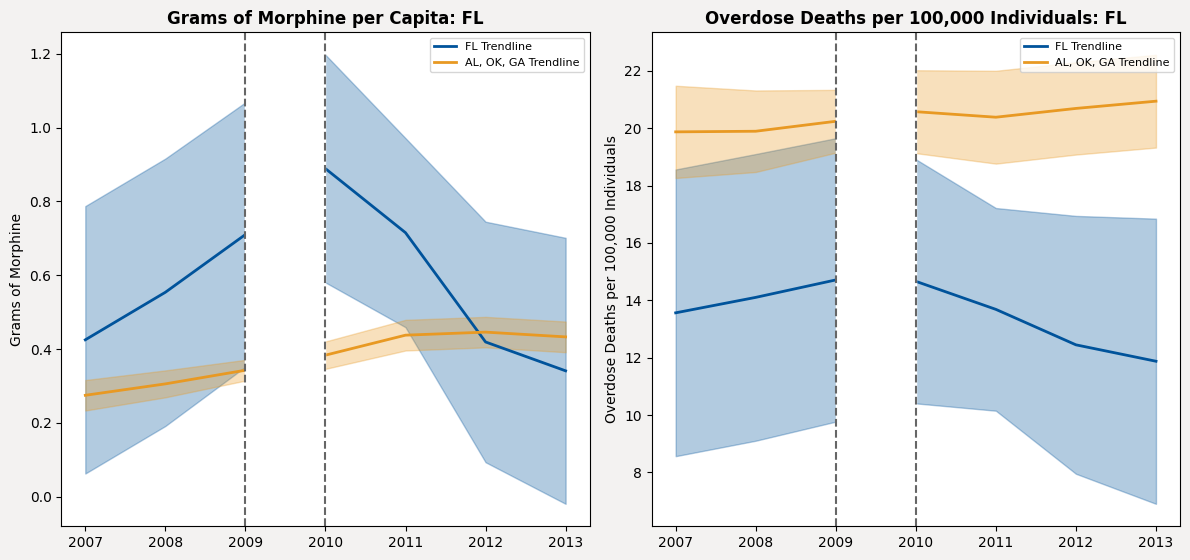

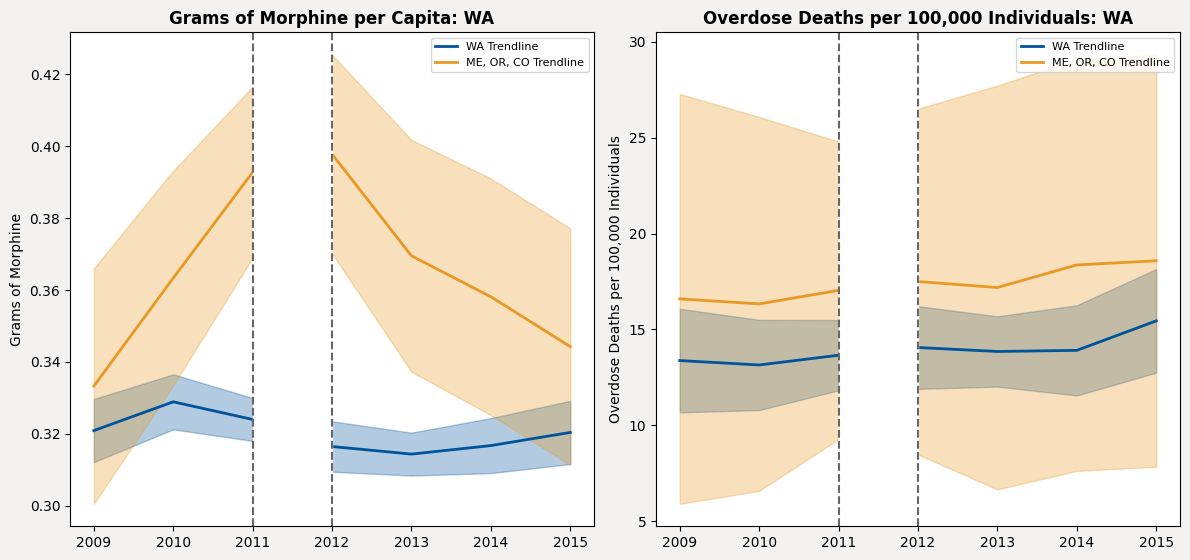

In [7]:
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np


def add_policy_year_break(ax, break_year_start, break_year_end):
    """Add a shaded vertical area to highlight the policy year range."""
    ax.axvspan(
        break_year_start,
        break_year_end,
        color="white",
        alpha=1.0,
        zorder=2,
        edgecolor=None,
    )
    return ax


def create_did_chart_splines_with_controls_and_extra_lines(
    final_dataset,
    treated_state,
    control_states,
    start_year,
    end_year,
    policy_year_start,
    policy_year_end,
    specific_lines,
):
    """Generate DID chart with splines, control states, and extra lines."""
    final_dataset["opioid_YEAR"] = pd.to_numeric(
        final_dataset["opioid_YEAR"], errors="coerce"
    )
    final_dataset = final_dataset.dropna(subset=["opioid_YEAR"])

    final_dataset = final_dataset[
        (final_dataset["opioid_YEAR"] >= start_year)
        & (final_dataset["opioid_YEAR"] <= end_year)
    ]

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "orange": "#E89923",
        "background": "#F3F2F1",
    }

    treated_data = final_dataset[final_dataset["State"] == treated_state]

    treated_aggregated = (
        treated_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    treated_aggregated["log_population"] = np.log(
        treated_aggregated["total_population"]
    )
    treated_aggregated["morphine_per_capita"] = (
        treated_aggregated["total_morphine"] / treated_aggregated["total_population"]
    )
    treated_aggregated["deaths_per_capita"] = (
        treated_aggregated["total_deaths"] / treated_aggregated["total_population"]
    )

    spline_year_treated = dmatrix(
        "bs(opioid_YEAR, degree=3, df=4)",
        data=treated_aggregated,
        return_type="dataframe",
    )

    morphine_model_treated = sm.OLS(
        treated_aggregated["morphine_per_capita"],
        sm.add_constant(
            pd.concat(
                [spline_year_treated, treated_aggregated["log_population"]], axis=1
            )
        ),
    ).fit()
    morphine_predictions_treated = morphine_model_treated.get_prediction(
        sm.add_constant(
            pd.concat(
                [spline_year_treated, treated_aggregated["log_population"]], axis=1
            )
        )
    ).summary_frame()
    treated_aggregated["morphine_predicted"] = morphine_predictions_treated["mean"]
    treated_aggregated["morphine_ci_low"] = morphine_predictions_treated[
        "mean_ci_lower"
    ]
    treated_aggregated["morphine_ci_high"] = morphine_predictions_treated[
        "mean_ci_upper"
    ]

    deaths_model_treated = sm.OLS(
        treated_aggregated["deaths_per_capita"],
        sm.add_constant(
            pd.concat(
                [spline_year_treated, treated_aggregated["log_population"]], axis=1
            )
        ),
    ).fit()
    deaths_predictions_treated = deaths_model_treated.get_prediction(
        sm.add_constant(
            pd.concat(
                [spline_year_treated, treated_aggregated["log_population"]], axis=1
            )
        )
    ).summary_frame()
    treated_aggregated["deaths_predicted"] = deaths_predictions_treated["mean"] * 100000
    treated_aggregated["deaths_ci_low"] = (
        deaths_predictions_treated["mean_ci_lower"] * 100000
    )
    treated_aggregated["deaths_ci_high"] = (
        deaths_predictions_treated["mean_ci_upper"] * 100000
    )

    control_data = final_dataset[final_dataset["State"].isin(control_states)]
    control_aggregated = (
        control_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    control_aggregated["log_population"] = np.log(
        control_aggregated["total_population"]
    )
    control_aggregated["morphine_per_capita"] = (
        control_aggregated["total_morphine"] / control_aggregated["total_population"]
    )
    control_aggregated["deaths_per_capita"] = (
        control_aggregated["total_deaths"] / control_aggregated["total_population"]
    )

    spline_year_control = dmatrix(
        "bs(opioid_YEAR, degree=3, df=4)",
        data=control_aggregated,
        return_type="dataframe",
    )

    morphine_model_control = sm.OLS(
        control_aggregated["morphine_per_capita"],
        sm.add_constant(
            pd.concat(
                [spline_year_control, control_aggregated["log_population"]], axis=1
            )
        ),
    ).fit()
    morphine_predictions_control = morphine_model_control.get_prediction(
        sm.add_constant(
            pd.concat(
                [spline_year_control, control_aggregated["log_population"]], axis=1
            )
        )
    ).summary_frame()
    control_aggregated["morphine_predicted"] = morphine_predictions_control["mean"]
    control_aggregated["morphine_ci_low"] = morphine_predictions_control[
        "mean_ci_lower"
    ]
    control_aggregated["morphine_ci_high"] = morphine_predictions_control[
        "mean_ci_upper"
    ]

    deaths_model_control = sm.OLS(
        control_aggregated["deaths_per_capita"],
        sm.add_constant(
            pd.concat(
                [spline_year_control, control_aggregated["log_population"]], axis=1
            )
        ),
    ).fit()
    deaths_predictions_control = deaths_model_control.get_prediction(
        sm.add_constant(
            pd.concat(
                [spline_year_control, control_aggregated["log_population"]], axis=1
            )
        )
    ).summary_frame()
    control_aggregated["deaths_predicted"] = deaths_predictions_control["mean"] * 100000
    control_aggregated["deaths_ci_low"] = (
        deaths_predictions_control["mean_ci_lower"] * 100000
    )
    control_aggregated["deaths_ci_high"] = (
        deaths_predictions_control["mean_ci_upper"] * 100000
    )

    fig = plt.figure(figsize=(12, 6), facecolor=duke_colors["background"])
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    # Chart 1: Morphine per capita
    ax1 = fig.add_subplot(spec[0])
    ax1.plot(
        treated_aggregated["opioid_YEAR"],
        treated_aggregated["morphine_predicted"],
        color=duke_colors["blue"],
        label=f"{treated_state} Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        treated_aggregated["opioid_YEAR"],
        treated_aggregated["morphine_ci_low"],
        treated_aggregated["morphine_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax1.plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_predicted"],
        color=duke_colors["orange"],
        label=f"{', '.join(control_states)} Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_ci_low"],
        control_aggregated["morphine_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax1 = add_policy_year_break(ax1, policy_year_start, policy_year_end)
    for line_year in specific_lines:
        ax1.axvline(
            x=line_year, color=duke_colors["gray"], linestyle="--", linewidth=1.5
        )
    ax1.set_title(
        f"Grams of Morphine per Capita: {treated_state}", fontsize=12, weight="bold"
    )
    ax1.legend(loc="upper right", fontsize=8, framealpha=0.8)
    ax1.set_ylabel("Grams of Morphine")

    # Chart 2: Overdose deaths per 100k
    ax2 = fig.add_subplot(spec[1])
    ax2.plot(
        treated_aggregated["opioid_YEAR"],
        treated_aggregated["deaths_predicted"],
        color=duke_colors["blue"],
        label=f"{treated_state} Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        treated_aggregated["opioid_YEAR"],
        treated_aggregated["deaths_ci_low"],
        treated_aggregated["deaths_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax2.plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_predicted"],
        color=duke_colors["orange"],
        label=f"{', '.join(control_states)} Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_ci_low"],
        control_aggregated["deaths_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax2 = add_policy_year_break(ax2, policy_year_start, policy_year_end)
    for line_year in specific_lines:
        ax2.axvline(
            x=line_year, color=duke_colors["gray"], linestyle="--", linewidth=1.5
        )
    ax2.set_title(
        f"Overdose Deaths per 100,000 Individuals: {treated_state}",
        fontsize=12,
        weight="bold",
    )
    ax2.legend(loc="upper right", fontsize=8, framealpha=0.8)
    ax2.set_ylabel("Overdose Deaths per 100,000 Individuals")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Call the function for Florida
create_did_chart_splines_with_controls_and_extra_lines(
    final_dataset=final_dataset,
    treated_state="FL",
    control_states=["AL", "OK", "GA"],
    start_year=2007,
    end_year=2013,
    policy_year_start=2009,
    policy_year_end=2010,
    specific_lines=[2009, 2010],
)

# Call the function for Washington
create_did_chart_splines_with_controls_and_extra_lines(
    final_dataset=final_dataset,
    treated_state="WA",
    control_states=["ME", "OR", "CO"],
    start_year=2009,
    end_year=2015,
    policy_year_start=2011,
    policy_year_end=2012,
    specific_lines=[2011, 2012],
)